In [1]:
import re
import numpy as np
import random
import os
import tensorflow as tf
#from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.initializers import GlorotUniform
from keras.utils import to_categorical
from keras.models import Model


from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from matplotlib import pylab
from scipy.stats import entropy

In [3]:
from collections import Counter
    
def to_sentiment(rating):
    if rating=='Extremely Negative':
        return 0
    elif rating == 'Extremely Positive':
        return 2
    elif rating == 'Neutral': 
        return 1
    else:
        return -1


filename = 'Corona_NLP_test.csv'
text_key = 'OriginalTweet'
class_key = 'Sentiment'
class1 = 0
class2 = 1
class3 = 2
df = pd.read_csv(filename)

df[class_key] = df[class_key].apply(lambda x:to_sentiment(x))

df = df[[text_key, class_key]]
df = df[[text_key, class_key]]
df.dropna(inplace=True)
array_total = df[ df[class_key].isin([class1]) ].to_numpy()#[:1000]
array_4 = df[ df[class_key].isin([class2]) ].to_numpy()#[:1000]
array_5 = df[ df[class_key].isin([class3]) ].to_numpy()#[:1000]
array_total = np.vstack( (array_total, array_4) )
array_total = np.vstack( (array_total, array_5) )
Text = array_total[:,0]
Class = array_total[:,1]
Class = Class.astype(int)

"\n#df = pd.read_csv('amazon_reviews.csv')\ndf = df[['reviewText', 'overall']]\ndf.dropna(inplace=True)\n#Counter( df['overall'].to_numpy() )\narray_total = df[ df['overall'].isin([1.0, 2.0, 3.0]) ].to_numpy()\narray_4 = df[ df['overall'].isin([4.0]) ].to_numpy()[:284]\narray_5 = df[ df['overall'].isin([5.0]) ].to_numpy()[:250]\narray_total = np.vstack( (array_total, array_4) )\narray_total = np.vstack( (array_total, array_5) )\nText = array_total[:,0]\nClass = array_total[:,1]-1\nClass = Class.astype(int)\n"

In [7]:
descripcion = {  'amazon_cells_labelled.txt': {'nombre': 'amazon', 'nclases': 5, 'fuente': "kaggle", 'n_ejemplos': 4904}  }
SEED=42


def reproducible_results(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(0)
    tf.compat.v1.set_random_seed(seed)

reproducible_results(SEED)

def OpenFunc(txt):   
    val_1=[]
    val_2=[]
    with open(txt, 'r') as file_object:
        val_1 = file_object.readlines()
    for i in range (0,len(val_1)):
        val_2.append(int(val_1[i][-2]))
        val_1[i]=val_1[i].replace(val_1[i][-2:-1],' ')#.replace('.',''))
    return np.array(val_1), np.array(val_2)


def PreproFunc(text):    
    for i in range(0,len(text)):
        text[i] = text[i].lower()
        text[i] = re.sub(r'[^a-z]', ' ',text[i])
        text[i] = re.sub(r'\s+', ' ',text[i]).strip()
        
        
    return text

def FuncVocab(x):
    vocab = []
    for i in x:
        word = i.split(' ')
        vocab.extend(word)
    vocab = np.array(list(set(vocab)))
    return vocab

Text = PreproFunc(Text)

def redneuronal(n_features, n_clases,mc=False ,seed=SEED):
    reproducible_results(seed)
    initializer = GlorotUniform(seed = seed)
    x_input = Input(shape=n_features)
    x = Dense(128, activation='relu', kernel_initializer=initializer, name= "Capa_1")(x_input)
    #x = Dropout(0.2,seed=SEED)(x, training=mc)
    x = Dense(64, activation='relu', kernel_initializer=initializer, name = "Capa_2")(x)
    x = Dropout(0.2,seed=SEED)(x, training=mc)
    x_out = Dense(n_clases, activation='softmax', kernel_initializer=initializer, name = "Capa_Salida")(x)
    model = Model(inputs=x_input, outputs=x_out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def metricas(metrica, curva):
    todas = []
    for i in range(5):
        una = []
        for ytrue, ypred, yl in curva[i]:
            if metrica == 'acc':   
                valor = accuracy_score(ytrue, ypred)
            elif metrica == 'f1':
                valor = f1_score(ytrue, ypred)
            una.append(valor) 
        todas.append(una)
    todas = np.mean(todas, axis = 0)
    return todas


#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
#clasificadores
clasificadores = { 'MNB':MultinomialNB(), 'SVM': SVC(random_state=SEED, kernel = 'linear', probability=True), 'RED': None, 'MNB_PL':MultinomialNB(), 'SVM_PL':SVC(random_state=SEED, kernel = 'linear', probability=True), 'RED_PL': None}
resultados = {}

In [8]:
BATCH= 64
NCLASES = 3
T = 10
epochs = 3
batch_size = 16
for key in clasificadores:
    if key == 'MNB_PL' or key == 'SVM_PL' or key == 'RED_PL':
        CurvaType = 'PL'
    else:
        CurvaType = 'AL'
    print(key)
    
    K = 1
    Curvas = []
    Axis_X = []
    History = []
    for train_index, test_index in kf.split(Text):
        Curva_Aux = []
        Axis_Aux_X = []
        History_Aux = []
        K+=1
        #K+=1
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = Text[train_index], Text[test_index]
        y_train, y_test = Class[train_index], Class[test_index]

        #datos entrenamiento Inicial
        X_l = X_train[:BATCH]
        y_l = y_train[:BATCH]

        auxnclass=len(np.unique(y_l))

        while(auxnclass!=NCLASES):
            X_train, y_train = shuffle(X_train, y_train, random_state= SEED)
            X_l = X_train[:BATCH]
            y_l = y_train[:BATCH]
            auxnclass=len(np.unique(y_l))

        #datos no etiquetados
        X_u = X_train[BATCH:]
        y_u = y_train[BATCH:]

        Axis_Aux_X.append(len(X_l))

        vectorizer = TfidfVectorizer(vocabulary=FuncVocab(X_l))
        X_l_tfidf = vectorizer.fit_transform(X_l).toarray()
        X_test_tfidf = vectorizer.transform(X_test).toarray()

        #variable X_u tfidf
        X_u_tfidf = vectorizer.transform(X_u).toarray()
           
        
        #Fit y Predict
        if 'RED' not in key:
            clf_clasificador = clasificadores[key]
            clf_clasificador.fit( X_l_tfidf, y_l)
            predict_clf = clf_clasificador.predict(X_test_tfidf)
        else:
            if CurvaType == 'PL':  
                clf_clasificador = redneuronal(X_l_tfidf.shape[1], NCLASES)
            else:
                clf_clasificador = redneuronal(X_l_tfidf.shape[1], NCLASES, True)
            H = clf_clasificador.fit( X_l_tfidf, to_categorical(y_l, NCLASES), verbose=0, epochs=epochs, batch_size=batch_size, validation_split=0.2)
            predict_clf = np.argmax(clf_clasificador.predict(X_test_tfidf), axis=1)
            
            
        print('acc', accuracy_score(y_test, predict_clf))
        
        
        Curva_Aux.append( [y_test, predict_clf, y_l] )
        if 'RED' in key:
            History_Aux.append([H.history['val_loss'], H.history['loss']])
        
        while(len(X_u)!=0):  
            
            if CurvaType== 'AL': 
                #if tipo de aprendizaje == activo:
                if len(X_u) >= BATCH:
                    #indexes = np.arange(BATCH) #aprendizaje aleatorio
                    #1) Predecir en Xu con predict_proba para obtener probabilidades
                    if 'RED' not in key:  
                        probs = clf_clasificador.predict_proba(X_u_tfidf)
                    else:
                        probs_Aux = []
                        for i in range(T):
                            probs_Aux.append(clf_clasificador.predict(X_u_tfidf))
                        probs_Aux = np.array(probs_Aux)
                        probs = np.mean(probs_Aux, axis = 0)
                    #2) calcular entropias}
                    entropias = []
                    for p in probs:
                        entropias.append(entropy(p, base=2))
                    entropias = np.array(entropias)
                    #3) Seleccionar los ejemplos con entropia maxima
                    indexes = np.argsort(entropias)[::-1][:BATCH]
                else:
                    indexes = np.arange(len(X_u))
            else:  
                if len(X_u) >= BATCH:
                    indexes = np.arange(BATCH)
                else:
                    indexes = np.arange(len(X_u))
                

            X_l = np.hstack((X_l,X_u[indexes]))  #index actualizado
            y_l = np.hstack((y_l,y_u[indexes]))  #index actualizado

            X_u = np.delete(X_u, indexes)  #index actualziado
            y_u = np.delete(y_u, indexes)  #index actualizado

            Axis_Aux_X.append(len(X_l))

            vectorizer = TfidfVectorizer(vocabulary=FuncVocab(X_l))
            X_l_tfidf = vectorizer.fit_transform(X_l).toarray()
            X_test_tfidf = vectorizer.transform(X_test).toarray()

            
            
            #variable X_u tfidf
            if len(X_u) > 0:
                X_u_tfidf = vectorizer.transform(X_u).toarray()
                
                
            ##Fit y Predict
            if 'RED' not in key:
                clf_clasificador = clasificadores[key]
                clf_clasificador.fit( X_l_tfidf, y_l)
                predict_clf = clf_clasificador.predict(X_test_tfidf)
            else:
                if CurvaType == 'PL':
                    clf_clasificador = redneuronal(X_l_tfidf.shape[1], NCLASES)
                else:
                    clf_clasificador = redneuronal(X_l_tfidf.shape[1], NCLASES, True)
                H = clf_clasificador.fit( X_l_tfidf, to_categorical(y_l, NCLASES), verbose=0, epochs=epochs, batch_size=batch_size, validation_split=0.2)
                predict_clf = np.argmax(clf_clasificador.predict(X_test_tfidf), axis=1)
                
                
            print('acc', accuracy_score(y_test, predict_clf))
            
            
            Curva_Aux.append( [y_test, predict_clf, y_l] )
            if 'RED' in key:
                History_Aux.append([H.history['val_loss'], H.history['loss']]) 
                
        if 'RED' in key:   
            History.append(History_Aux)
        Curvas.append(Curva_Aux)
        Axis_X.append(Axis_Aux_X)
    #resultados[key] = np.array(Curvas).mean(axis=0)
    resultados[key] = np.array(Curvas)
    if 'RED' in key:
        resultados[key+'_History'] = np.array(History).mean(axis=0)
resultados['Axis_X'] = np.array(Axis_X).mean(axis=0).astype(int)

MNB
acc 0.5220994475138122
acc 0.4281767955801105
acc 0.511049723756906
acc 0.5966850828729282
acc 0.6546961325966851
acc 0.6657458563535912
acc 0.6961325966850829
acc 0.6629834254143646
acc 0.6685082872928176
acc 0.7237569060773481
acc 0.6988950276243094
acc 0.7513812154696132
acc 0.7044198895027625
acc 0.7071823204419889
acc 0.7154696132596685
acc 0.7265193370165746
acc 0.7099447513812155
acc 0.7154696132596685
acc 0.7320441988950276
acc 0.7430939226519337
acc 0.7348066298342542
acc 0.7403314917127072
acc 0.7375690607734806
acc 0.5276243093922652
acc 0.34806629834254144
acc 0.5718232044198895
acc 0.643646408839779
acc 0.5994475138121547
acc 0.6712707182320442
acc 0.7154696132596685
acc 0.7016574585635359
acc 0.6878453038674033
acc 0.6988950276243094
acc 0.6933701657458563
acc 0.7237569060773481
acc 0.7265193370165746
acc 0.7486187845303868
acc 0.7513812154696132
acc 0.7486187845303868
acc 0.7651933701657458
acc 0.7320441988950276
acc 0.7458563535911602
acc 0.7458563535911602
acc 0.73

C:\Users\Pc Gamer\AppData\Local\Temp\ipykernel_13544\384580975.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultados[key] = np.array(Curvas)


acc 0.5552486187845304
acc 0.5966850828729282
acc 0.6408839779005525
acc 0.6325966850828729
acc 0.6574585635359116
acc 0.6795580110497238
acc 0.7182320441988951
acc 0.7237569060773481
acc 0.7513812154696132
acc 0.7403314917127072
acc 0.7375690607734806
acc 0.7541436464088398
acc 0.7430939226519337
acc 0.7486187845303868
acc 0.7403314917127072
acc 0.7513812154696132
acc 0.7541436464088398
acc 0.7651933701657458
acc 0.7624309392265194
acc 0.7569060773480663
acc 0.7569060773480663
acc 0.7513812154696132
acc 0.5552486187845304
acc 0.5552486187845304
acc 0.5966850828729282
acc 0.6408839779005525
acc 0.643646408839779
acc 0.6685082872928176
acc 0.6906077348066298
acc 0.7375690607734806
acc 0.7265193370165746
acc 0.7154696132596685
acc 0.7292817679558011
acc 0.7430939226519337
acc 0.7541436464088398
acc 0.7458563535911602
acc 0.7569060773480663
acc 0.7596685082872928
acc 0.7679558011049724
acc 0.7624309392265194
acc 0.7596685082872928
acc 0.7651933701657458
acc 0.7624309392265194
acc 0.762430

C:\Users\Pc Gamer\AppData\Local\Temp\ipykernel_13544\384580975.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultados[key] = np.array(Curvas)


12/12 [==============================] - 0s 2ms/step
acc 0.34806629834254144
12/12 [==============================] - 0s 2ms/step
acc 0.3259668508287293
12/12 [==============================] - 0s 2ms/step
acc 0.4889502762430939
12/12 [==============================] - 0s 2ms/step
acc 0.4143646408839779
12/12 [==============================] - 0s 2ms/step
acc 0.5773480662983426
12/12 [==============================] - 0s 2ms/step
acc 0.5773480662983426
12/12 [==============================] - 0s 2ms/step
acc 0.5828729281767956
12/12 [==============================] - 0s 3ms/step
acc 0.643646408839779
12/12 [==============================] - 0s 3ms/step
acc 0.6629834254143646
12/12 [==============================] - 0s 2ms/step
acc 0.6740331491712708
12/12 [==============================] - 1s 10ms/step
acc 0.7044198895027625
12/12 [==============================] - 0s 2ms/step
acc 0.7044198895027625
12/12 [==============================] - 0s 2ms/step
acc 0.7182320441988951
12/12 [====

C:\Users\Pc Gamer\AppData\Local\Temp\ipykernel_13544\384580975.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultados[key] = np.array(Curvas)


acc 0.5027624309392266
acc 0.643646408839779
acc 0.6574585635359116
acc 0.6602209944751382
acc 0.6464088397790055
acc 0.6712707182320442
acc 0.6602209944751382
acc 0.6767955801104972
acc 0.6712707182320442
acc 0.7071823204419889
acc 0.6988950276243094
acc 0.6961325966850829
acc 0.712707182320442
acc 0.7044198895027625
acc 0.7237569060773481
acc 0.7237569060773481
acc 0.7237569060773481
acc 0.7182320441988951
acc 0.7320441988950276
acc 0.7403314917127072
acc 0.7403314917127072
acc 0.7375690607734806
acc 0.5276243093922652
acc 0.4419889502762431
acc 0.6574585635359116
acc 0.6795580110497238
acc 0.6906077348066298
acc 0.6574585635359116
acc 0.6933701657458563
acc 0.6961325966850829
acc 0.6933701657458563
acc 0.712707182320442
acc 0.7099447513812155
acc 0.712707182320442
acc 0.7099447513812155
acc 0.7154696132596685
acc 0.6878453038674033
acc 0.6878453038674033
acc 0.6933701657458563
acc 0.6961325966850829
acc 0.7099447513812155
acc 0.6906077348066298
acc 0.7237569060773481
acc 0.715469613

C:\Users\Pc Gamer\AppData\Local\Temp\ipykernel_13544\384580975.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultados[key] = np.array(Curvas)


SVM_PL
acc 0.5607734806629834
acc 0.6049723756906077
acc 0.6519337016574586
acc 0.643646408839779
acc 0.6519337016574586
acc 0.6519337016574586
acc 0.6546961325966851
acc 0.6629834254143646
acc 0.6712707182320442
acc 0.6795580110497238
acc 0.7071823204419889
acc 0.7099447513812155
acc 0.7071823204419889
acc 0.7237569060773481
acc 0.712707182320442
acc 0.712707182320442
acc 0.7182320441988951
acc 0.7154696132596685
acc 0.7265193370165746
acc 0.7320441988950276
acc 0.7209944751381215
acc 0.7541436464088398
acc 0.7513812154696132
acc 0.5552486187845304
acc 0.569060773480663
acc 0.6464088397790055
acc 0.6657458563535912
acc 0.6850828729281768
acc 0.6906077348066298
acc 0.6988950276243094
acc 0.6961325966850829
acc 0.7154696132596685
acc 0.7071823204419889
acc 0.7348066298342542
acc 0.7292817679558011
acc 0.7292817679558011
acc 0.7513812154696132
acc 0.7403314917127072
acc 0.7458563535911602
acc 0.7596685082872928
acc 0.7624309392265194
acc 0.7679558011049724
acc 0.7541436464088398
acc 0.75

C:\Users\Pc Gamer\AppData\Local\Temp\ipykernel_13544\384580975.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultados[key] = np.array(Curvas)


12/12 [==============================] - 0s 2ms/step
acc 0.35359116022099446
12/12 [==============================] - 0s 2ms/step
acc 0.4861878453038674
12/12 [==============================] - 0s 2ms/step
acc 0.585635359116022
12/12 [==============================] - 0s 2ms/step
acc 0.6243093922651933
12/12 [==============================] - 0s 2ms/step
acc 0.5718232044198895
12/12 [==============================] - 0s 2ms/step
acc 0.6049723756906077
12/12 [==============================] - 0s 2ms/step
acc 0.6298342541436464
12/12 [==============================] - 0s 3ms/step
acc 0.6878453038674033
12/12 [==============================] - 0s 2ms/step
acc 0.6464088397790055
12/12 [==============================] - 0s 2ms/step
acc 0.6878453038674033
12/12 [==============================] - 0s 3ms/step
acc 0.6961325966850829
12/12 [==============================] - 0s 2ms/step
acc 0.6850828729281768
12/12 [==============================] - 0s 3ms/step
acc 0.7265193370165746
12/12 [=====

C:\Users\Pc Gamer\AppData\Local\Temp\ipykernel_13544\384580975.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resultados[key] = np.array(Curvas)


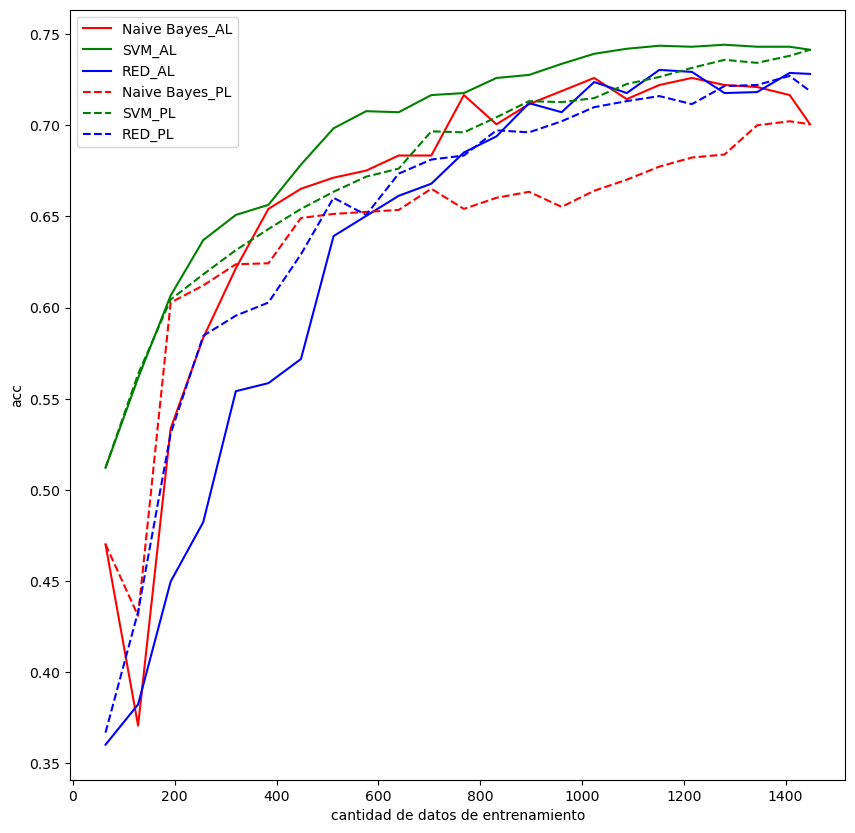

In [15]:
#for tipo in CurveType:
metrica = 'acc'
fig = pylab.figure(1,figsize=(10,10))



pylab.plot(resultados['Axis_X'], metricas(metrica, resultados['MNB']), 'r', label = 'Naive Bayes_AL')
pylab.plot(resultados['Axis_X'], metricas(metrica, resultados['SVM']), 'g', label = 'SVM_AL')
pylab.plot(resultados['Axis_X'], metricas(metrica, resultados['RED']), 'b', label = 'RED_AL') #label = 'RED-'+tipo
pylab.plot(resultados['Axis_X'], metricas(metrica, resultados['MNB_PL']), 'r--', label = 'Naive Bayes_PL')
pylab.plot(resultados['Axis_X'], metricas(metrica, resultados['SVM_PL']), 'g--', label = 'SVM_PL')
pylab.plot(resultados['Axis_X'], metricas(metrica, resultados['RED_PL']), 'b--', label = 'RED_PL')

pylab.xlabel("cantidad de datos de entrenamiento")
pylab.ylabel(metrica)
pylab.legend()


pylab.show()

In [16]:
hiper_parametros = {'SVM':clasificadores['SVM'].get_params(),
                   'MNB': clasificadores['MNB'].get_params(),
                   'RED': {'capas_ocultas': 2, 'epocas': epochs, 'batch': BATCH, 'funciones_acti': "relu y softmax", 'optimizador': "adam"}}

import pickle

diccionario= {'resultados':resultados,
             'descripcion':descripcion,
             'hiperparametros':hiper_parametros}

with open('resultados_curvas_multiclase.pkl','wb') as a:
    pickle.dump(diccionario, a, protocol=2)

In [19]:
from wordcloud import WordCloud, STOPWORDS
df = pd.DataFrame()
df['Textos']=pd.DataFrame(Text)
df['Clases'] = pd.DataFrame(Class)
df_negative = df[df['Clases']==0]
df_positive = df[df['Clases']!=0]

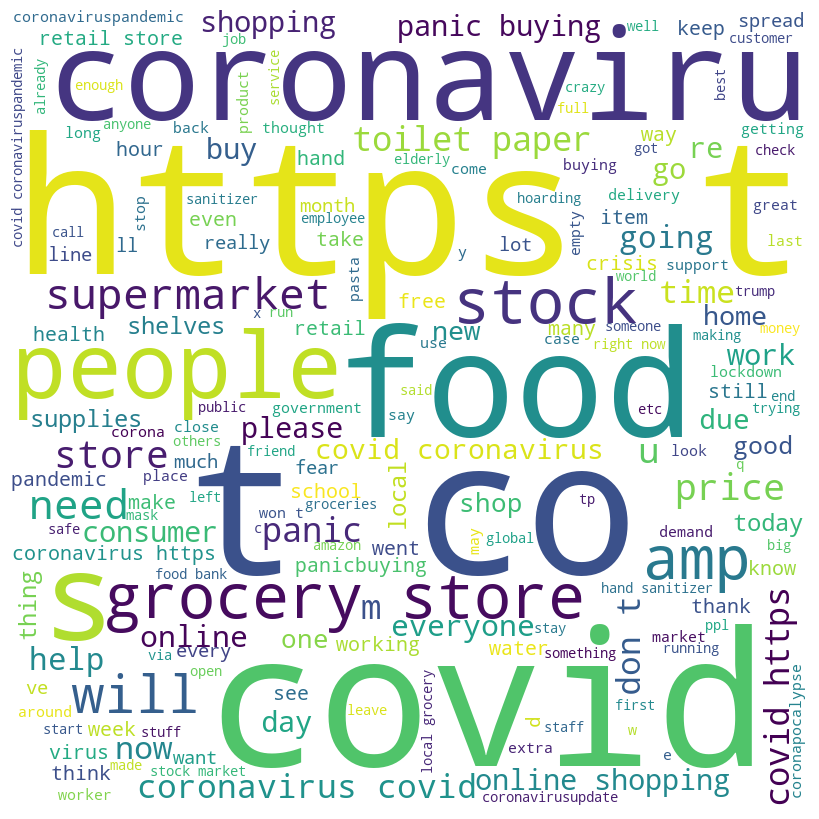

In [20]:
comment_words = ''
stopwords = set(STOPWORDS)
# iterate through the csv file
for val in df.Textos:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)


# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()